In [2]:
import argparse
import os
import sys
import warnings


from matplotlib import pyplot as plt

import numpy as np
from tqdm import tqdm
import itertools
import pickle
import cv2

In [3]:
from keras_retinanet.preprocessing.sail_val_generator import SAIL_val_Generator

In [4]:
from keras_retinanet.utils.eval import _get_annotations, _get_detections

In [5]:
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 300

In [6]:
from argparse import Namespace

In [7]:
def create_test_generator(args):
    common_args = {
        'batch_size'       : args.batch_size,
        'config'           : args.config,
        'image_min_side'   : args.image_min_side,
        'image_max_side'   : args.image_max_side,
    }

    if args.annotations:
        if 'val_steps' in dir(args):
            validation_generator = SAIL_val_Generator(args.val_annotations,
                                                      args.classes,
                                                      transform_generator=None,
                                                      val_steps=args.val_steps,
                                                      **common_args)
        else:
            validation_generator = SAIL_val_Generator(args.val_annotations,
                                                      args.classes,
                                                      transform_generator=None,
                                                      **common_args)
    return validation_generator

In [8]:
args = Namespace(image_min_side=1024,
                 val_batch_size=16,
                 backbone='resnet152',
                 weights='/app/Ant_mcs_detection/detection_retinanet/snapshots/resnet152_003a/resnet152_sail_12.h5',
                 annotations = '/app/Ant_mcs_detection/train_data_001/test/labels_all.pkl',
                 classes = '/app/Ant_mcs_detection/train_data_001/retinanet_classes.csv',
                 val_annotations='/app/Ant_mcs_detection/train_data_001/test/labels_all.pkl',
                 imagenet_weights = True, batch_size=16, epochs=10, steps=1024,
                 config = None, image_max_side = 1333, shrinking_proba_perc_threshold=80)

In [9]:
test_generator = create_test_generator(args)

reading annotatiuons file...
annotatiuons file read in 0.122243s...


In [10]:
if os.path.exists('/app/Ant_mcs_detection/output/test_set_all_detections.pkl'):
    with open('/app/Ant_mcs_detection/output/test_set_all_detections.pkl', 'rb') as f:
        all_detections = pickle.load(f)

In [11]:
all_detections[0][0].shape

(100, 5)

In [12]:
all_annotations = _get_annotations(test_generator, predicted_items_count=len(all_detections))

Parsing annotations: 100% (9984 of 9984) || Elapsed Time: 0:00:00 Time:  0:00:00


In [13]:
proba_percentiles = np.linspace(10, 99, 90)
iou_values_per_example = []

# for example_idx in tqdm(range(len(all_annotations)), total=len(all_annotations)):
for example_idx in tqdm(np.random.permutation(len(all_annotations))[:500], total = 500):
    image       = test_generator.load_image(example_idx)
    annotations = test_generator.load_annotations(example_idx)
#     anchors = anchors_for_shape(image.shape, anchor_params=None)
#     positive_indices, _, max_indices = compute_gt_annotations(anchors, annotations['bboxes'])

    curr_detections = all_detections[example_idx][0]
    # selected_detections = curr_detections[curr_detections[:, -1] >= args.proba_threshold, :]
    # bboxes = selected_detections[:, :4]
    # probas = selected_detections[:, -1]
    bboxes = curr_detections[:, :4]
    probas = curr_detections[:, -1]

    # region filter detections


    iou_values = np.zeros_like(proba_percentiles)
    for idx,proba_perc in enumerate(proba_percentiles):
        bboxes_filtered = np.copy(bboxes)
        scores_filtered = np.copy(probas)
        proba_threshold = np.percentile(scores_filtered, proba_perc)
        filter_indices = np.where(scores_filtered >= proba_threshold)[0]
        bboxes_filtered = bboxes_filtered[filter_indices, :]
        scores_filtered = scores_filtered[filter_indices]

        im_true = np.zeros_like(image[:,:,0], dtype=np.uint8)
        for i in range(annotations['bboxes'].shape[0]):
            box = annotations['bboxes'][i]
            x1, y1, x2, y2 = np.array(box).astype(int)
            im_true[y1:y2, x1:x2] = 1
        im_pred = np.zeros_like(image[:,:,0], dtype=np.uint8)
        for bbox in bboxes_filtered:
            x1, y1, x2, y2 = bbox.astype(int)
            im_pred[y1:y2, x1:x2] = 1
        intersection = cv2.bitwise_and(im_true, im_pred)
        union = cv2.bitwise_or(im_true, im_pred)
        iou = intersection.sum() / union.sum()
        iou_values[idx] = iou

    iou_values_per_example.append(iou_values[:,np.newaxis])
    if example_idx == 32:
        break

100%|██████████| 500/500 [02:46<00:00,  3.02it/s]


In [14]:
iou_values_per_example[0].shape

(90, 1)

In [15]:
iou_values_per_example = np.concatenate(iou_values_per_example, axis=-1)
iou_values_per_example.shape

(90, 500)

In [16]:
iou_values_per_example_mean = np.mean(iou_values_per_example, axis = -1)

In [17]:
iou_values_per_example_std = np.mean(iou_values_per_example, axis = -1)

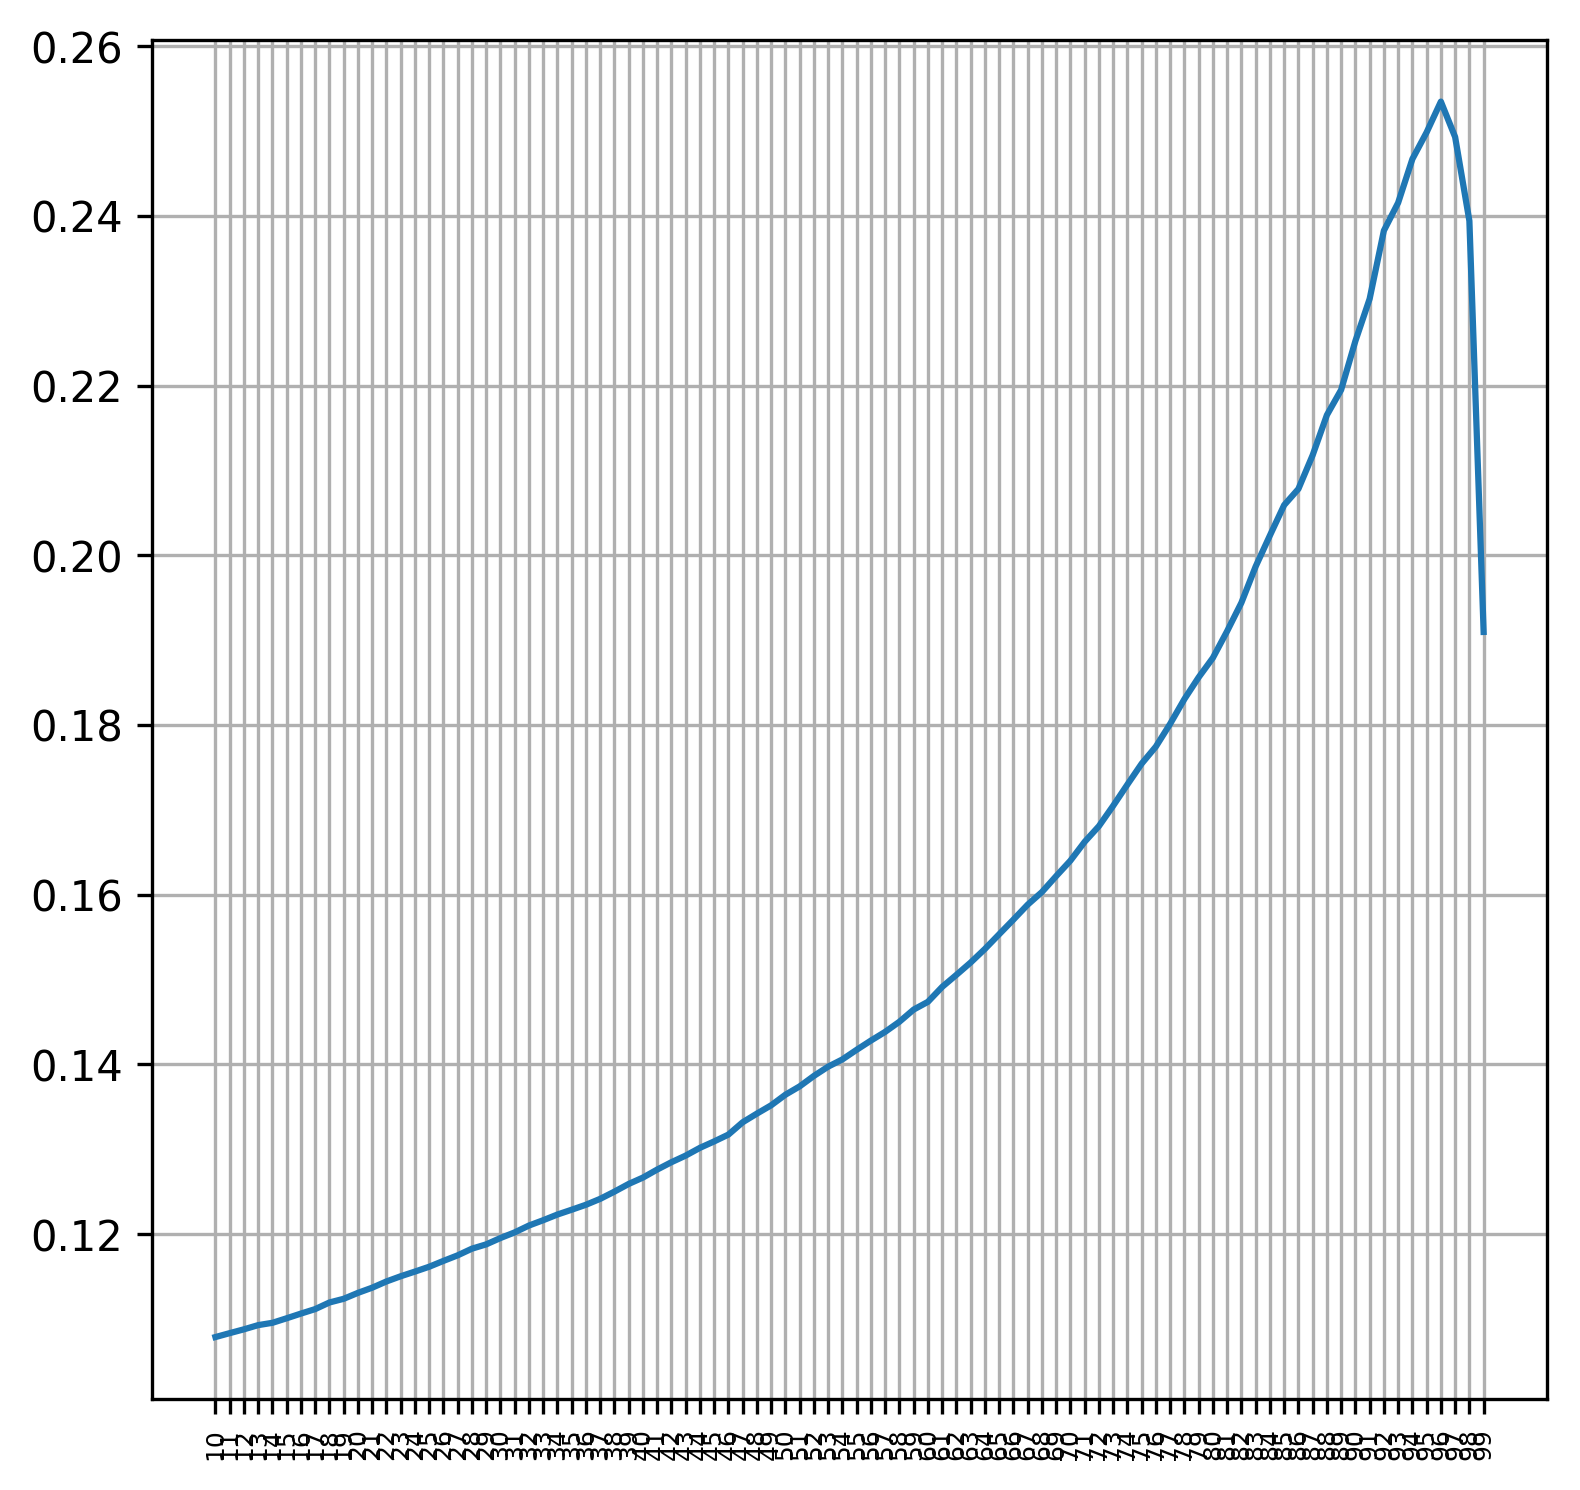

In [19]:
_ = plt.plot(proba_percentiles, iou_values_per_example_mean)
# _ = plt.fill_between(proba_percentiles,
#                      iou_values_per_example_mean-iou_values_per_example_std,
#                      iou_values_per_example_mean+iou_values_per_example_std, alpha=0.3)
_ = plt.xticks(proba_percentiles, fontsize=6, rotation=90)
_ = plt.grid(True, which='both')

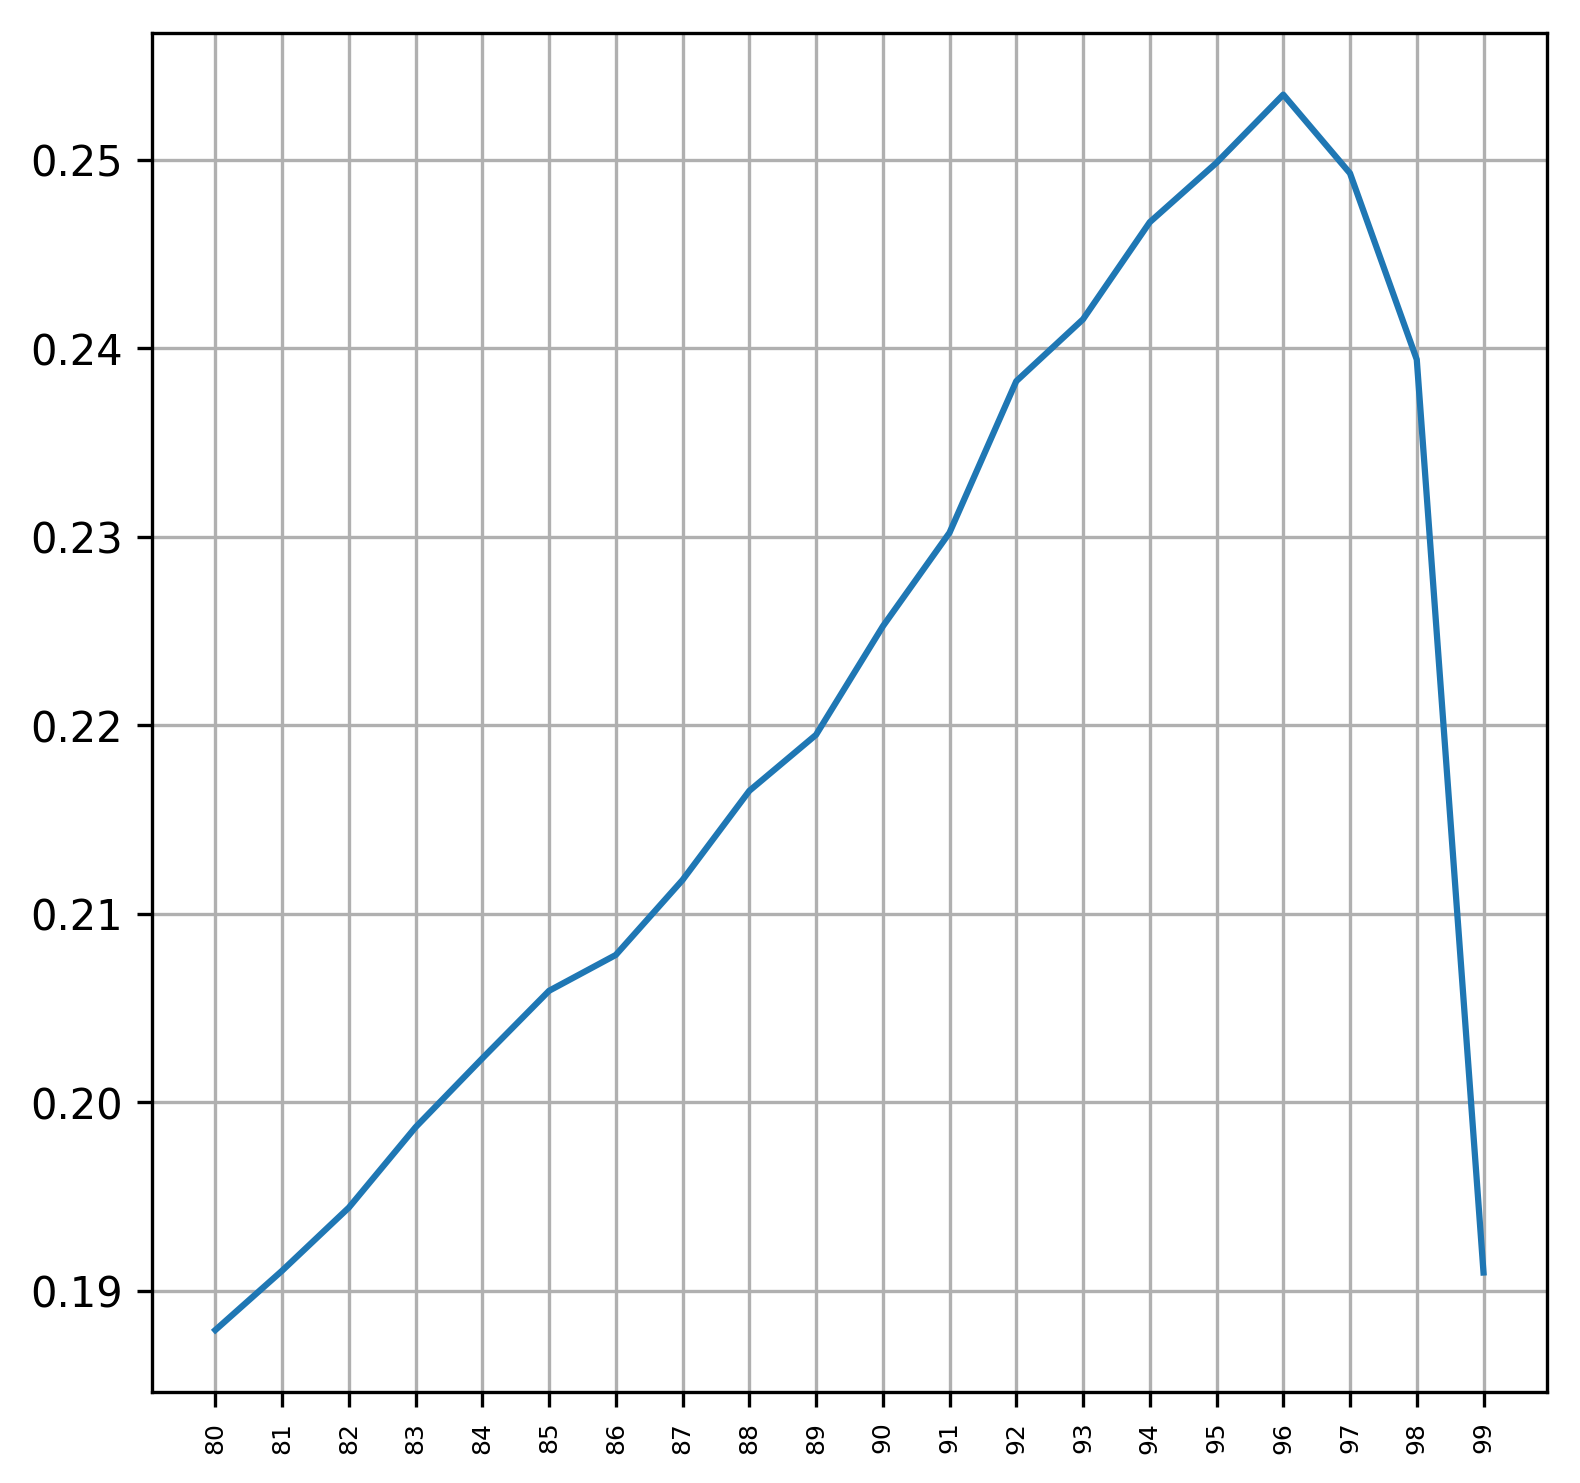

In [20]:
_ = plt.plot(proba_percentiles[-20:], iou_values_per_example_mean[-20:])
# _ = plt.fill_between(proba_percentiles[-20:],
#                      iou_values_per_example_mean[-20:]-iou_values_per_example_std[-20:],
#                      iou_values_per_example_mean[-20:]+iou_values_per_example_std[-20:], alpha=0.3)
_ = plt.xticks(proba_percentiles[-20:], fontsize=6, rotation=90)
_ = plt.grid(True, which='both')